In [67]:
# packages for data loading, data analysis, and data preparation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import model_functions
from sklearn.preprocessing import StandardScaler

# imports for database
import psycopg2 as pg
from db_connection import connect

# imports for modeling
from sklearn.model_selection import train_test_split,KFold,cross_validate,GridSearchCV,\
RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from joblib import dump,load

In [14]:
# read data from db
sql = 'SELECT * FROM processed_bitcoin'
df = pd.read_sql_query(sql=sql,con=connect())

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 13.2 on x86_64-apple-darwin, compiled by Apple clang version 11.0.3 (clang-1103.0.32.59), 64-bit',)
Connection successful


In [15]:
df.tail(10)

,prediction_date,open_price_1,open_price_2,open_price_3,open_price_4,open_price_5,open_price_6,high_1,high_2,high_3,...,close_price_4,close_price_5,close_price_6,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,signal
2606,2022-02-28,37068.77,38285.28,37278.57,38333.75,39213.08,39098.70,38359.86,39122.39,38968.84,...,39214.22,39105.15,37709.79,25493150450,21849073843,46383802093,26545599159,17467554129,23450127612,0
2607,2022-03-01,38285.28,37278.57,38333.75,39213.08,39098.70,37706.00,39122.39,38968.84,39630.32,...,39105.15,37709.79,43193.23,21849073843,46383802093,26545599159,17467554129,23450127612,35690014104,0
2608,2022-03-02,37278.57,38333.75,39213.08,39098.70,37706.00,43194.50,38968.84,39630.32,40005.35,...,37709.79,43193.23,44354.64,46383802093,26545599159,17467554129,23450127612,35690014104,32479047645,0
2609,2022-03-03,38333.75,39213.08,39098.70,37706.00,43194.50,44357.62,39630.32,40005.35,39778.94,...,43193.23,44354.64,43924.12,26545599159,17467554129,23450127612,35690014104,32479047645,29183112630,1
2610,2022-03-04,39213.08,39098.70,37706.00,43194.50,44357.62,43925.20,40005.35,39778.94,43760.46,...,44354.64,43924.12,42451.79,17467554129,23450127612,35690014104,32479047645,29183112630,24967782593,1
2611,2022-03-05,39098.70,37706.00,43194.50,44357.62,43925.20,42458.14,39778.94,43760.46,44793.60,...,43924.12,42451.79,39137.61,23450127612,35690014104,32479047645,29183112630,24967782593,28516271427,1
2612,2022-03-06,37706.00,43194.50,44357.62,43925.20,42458.14,39148.45,43760.46,44793.60,45077.58,...,42451.79,39137.61,39400.59,35690014104,32479047645,29183112630,24967782593,28516271427,16975917450,1
2613,2022-03-07,43194.50,44357.62,43925.20,42458.14,39148.45,39404.20,44793.60,45077.58,44021.58,...,39137.61,39400.59,38419.98,32479047645,29183112630,24967782593,28516271427,16975917450,19745229902,1
2614,2022-03-08,44357.62,43925.20,42458.14,39148.45,39404.20,38429.30,45077.58,44021.58,42479.61,...,39400.59,38419.98,38062.04,29183112630,24967782593,28516271427,16975917450,19745229902,28546143503,1
2615,2022-03-09,43925.20,42458.14,39148.45,39404.20,38429.30,38059.90,44021.58,42479.61,39566.34,...,38419.98,38062.04,38737.27,24967782593,28516271427,16975917450,19745229902,28546143503,25776583476,1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2616 entries, 0 to 2615
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   prediction_date  2616 non-null   object 
 1   open_price_1     2616 non-null   float64
 2   open_price_2     2616 non-null   float64
 3   open_price_3     2616 non-null   float64
 4   open_price_4     2616 non-null   float64
 5   open_price_5     2616 non-null   float64
 6   open_price_6     2616 non-null   float64
 7   high_1           2616 non-null   float64
 8   high_2           2616 non-null   float64
 9   high_3           2616 non-null   float64
 10  high_4           2616 non-null   float64
 11  high_5           2616 non-null   float64
 12  high_6           2616 non-null   float64
 13  low_1            2616 non-null   float64
 14  low_2            2616 non-null   float64
 15  low_3            2616 non-null   float64
 16  low_4            2616 non-null   float64
 17  low_5         

In [17]:
# quantify buy and sell to check for imbalance
class_name ={0:'sell',1:'buy'}
df['signal'].value_counts().rename(index=class_name)/len(df)

buy     0.567278
sell    0.432722
Name: signal, dtype: float64

In [18]:
# shuffle the data 
df = df.sample(frac=1)

In [19]:
df.head(10)

,prediction_date,open_price_1,open_price_2,open_price_3,open_price_4,open_price_5,open_price_6,high_1,high_2,high_3,...,close_price_4,close_price_5,close_price_6,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,signal
1739,2019-10-10,8259.49,8210.15,8149.88,7989.12,8246.85,8229.84,8260.06,8215.53,8161.41,...,8245.62,8228.78,8595.74,13139456229,12200497197,13160830305,18009742607,15592264032,19384942333,0
1783,2019-11-24,8573.98,8305.13,8203.61,8023.64,7643.57,7296.16,8653.28,8408.52,8237.24,...,7642.75,7296.58,7397.80,21579470673,21083613816,20764300437,22514243371,34242315785,21008924418,1
1253,2018-06-12,7625.97,7650.82,7685.14,7632.52,7499.55,6799.29,7680.43,7741.27,7698.19,...,7531.98,6786.02,6906.92,4692259840,4485799936,4227579904,3845220096,5804839936,4745269760,1
1176,2018-03-27,8937.48,8939.44,8736.25,8901.95,8612.81,8498.47,9177.37,9100.71,8879.62,...,8668.12,8495.78,8209.40,6043129856,5530390016,5954120192,5664600064,4569880064,5921039872,0
1213,2018-05-03,9290.63,8939.27,9346.41,9426.11,9251.47,9104.60,9375.47,9412.09,9531.49,...,9240.55,9119.01,9235.92,7566289920,7805479936,8853000192,8673920000,7713019904,7558159872,0
1772,2019-11-13,9352.39,9265.37,8809.47,8812.49,9056.92,8759.75,9368.48,9272.76,8891.82,...,9055.53,8757.79,8815.66,22700383839,24333037836,17578630606,20587919881,20265510765,20309769107,0
1042,2017-11-13,7023.10,7141.38,7446.83,7173.73,6618.61,6295.45,7253.32,7776.42,7446.83,...,6618.14,6357.60,5950.07,2326340096,4602200064,3226249984,5208249856,4908680192,8957349888,1
1291,2018-07-20,6247.50,6272.70,6357.01,6739.65,7315.32,7378.20,6298.19,6403.46,6741.75,...,7321.04,7370.78,7466.86,2923670016,3285459968,4725799936,5961950208,6103410176,5111629824,1
1892,2020-03-12,9078.31,9121.60,8908.21,8111.15,7922.15,7910.09,9167.70,9163.22,8914.34,...,7923.64,7909.73,7911.43,40826885651,36216930370,39973102121,46936995808,42213940994,38682762605,1
414,2016-02-24,416.57,422.73,421.60,437.77,438.99,438.26,426.00,423.10,441.98,...,438.80,437.75,420.74,76752600,55711300,93992096,89820704,85385200,85244896,0


In [20]:
# create isolated test data
test_data = df[:200]

In [21]:
# data used for modeling
data = df[200:]

In [22]:
# drop date column
data.drop('prediction_date',axis=1,inplace=True)

/Users/faithful/anaconda3/envs/venv/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [23]:
# train test split
# split the data into train test split, create test size & random seed
X = data.drop('signal',axis=1)
y = data['signal']
validation_size = 0.2
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [24]:
# scale the inputs of the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Building

In [25]:
# models we will be testing out [(name,model)]
models = [('LR',LogisticRegression(max_iter=300)),
          ('KNN',KNeighborsClassifier()),
          ('SVC',SVC()),
          ('XGB',XGBClassifier()),
          ('DTC',DecisionTreeClassifier()),
          ('ADA',AdaBoostClassifier()),
          ('RF', RandomForestClassifier()),
          ('ET',ExtraTreesClassifier())]

100%|█████████████████████████████████████████████| 8/8 [00:28<00:00,  3.58s/it]


[]

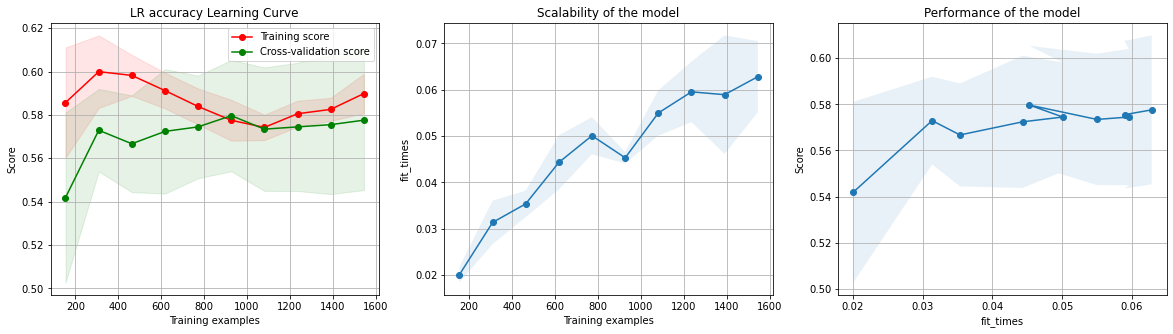

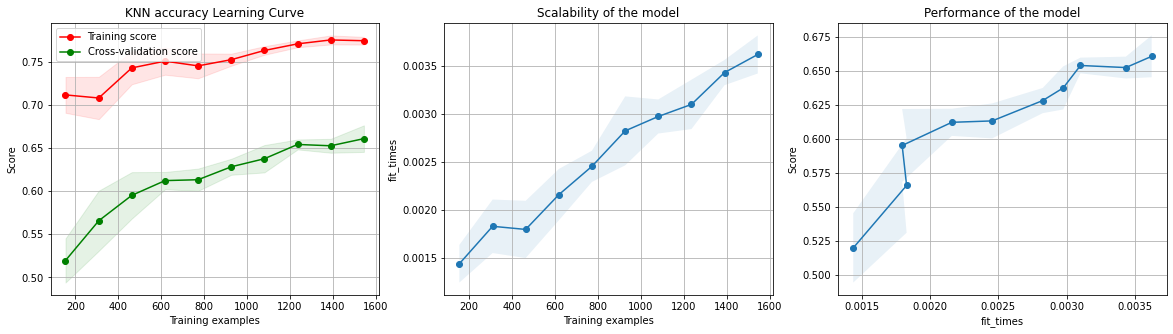

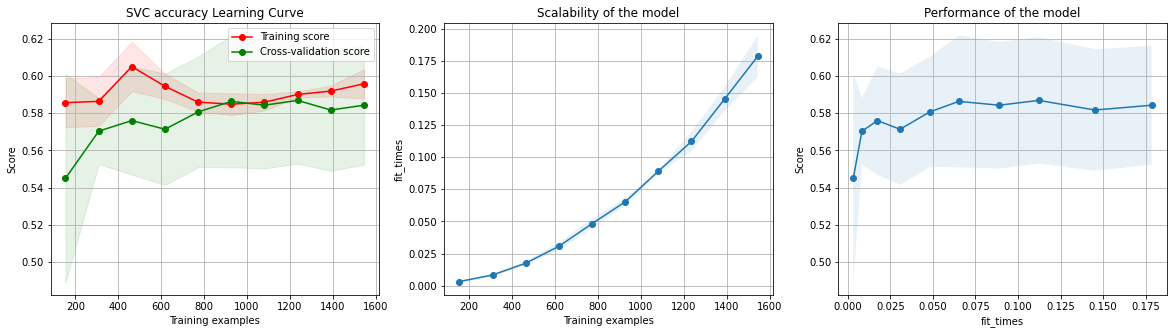

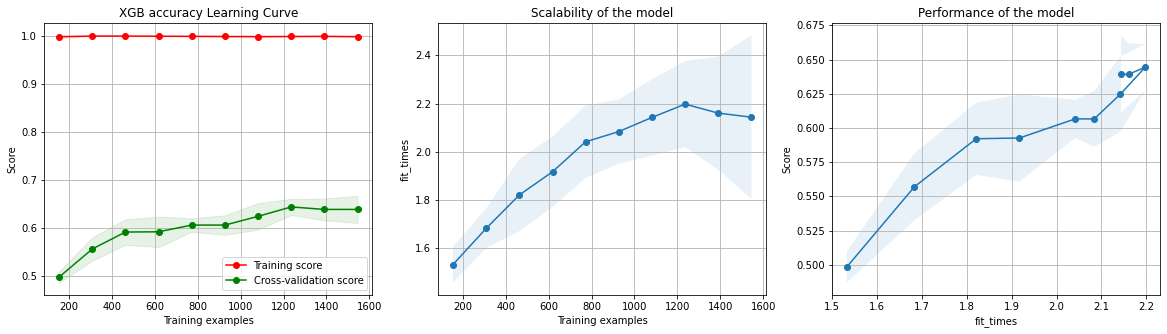

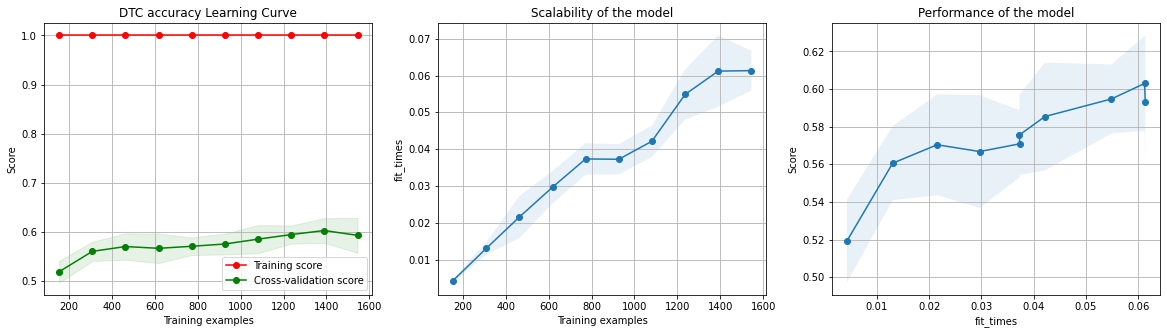

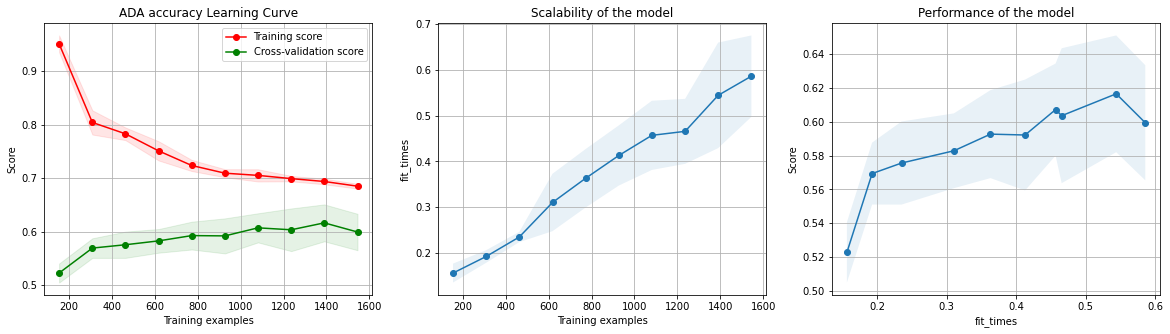

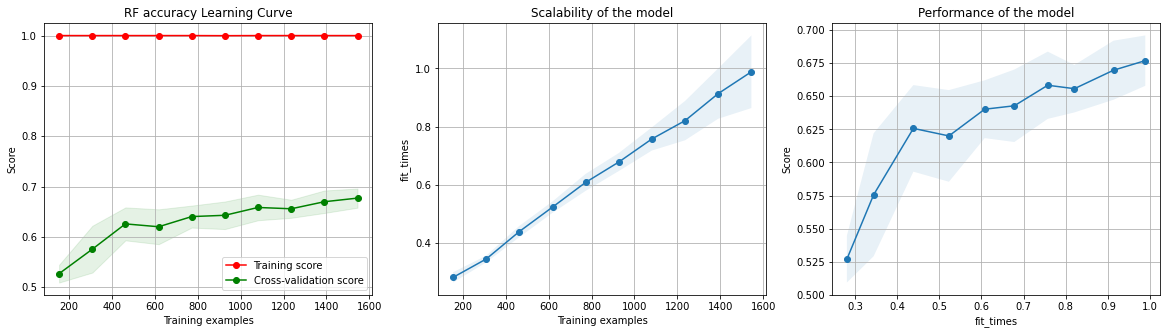

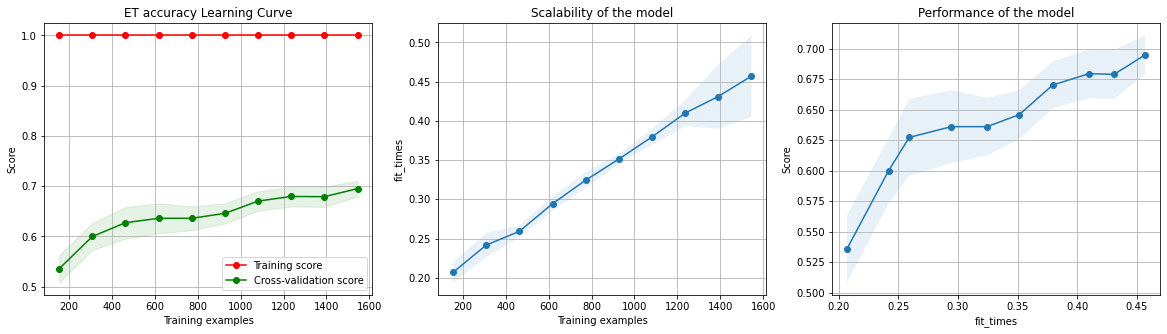

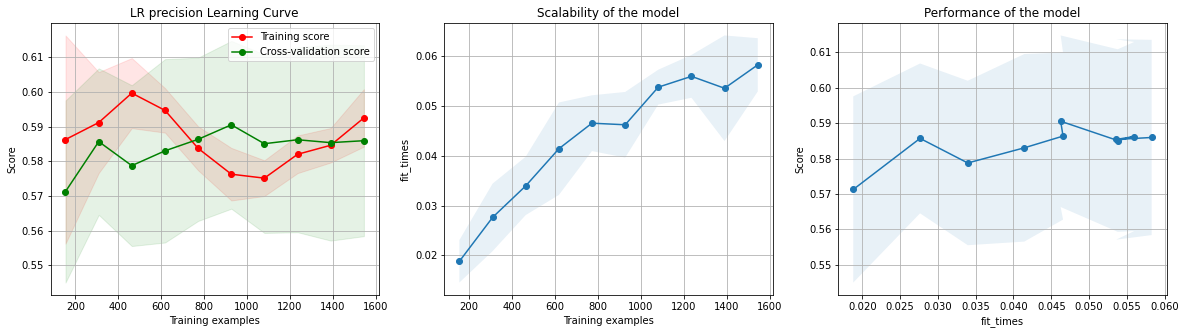

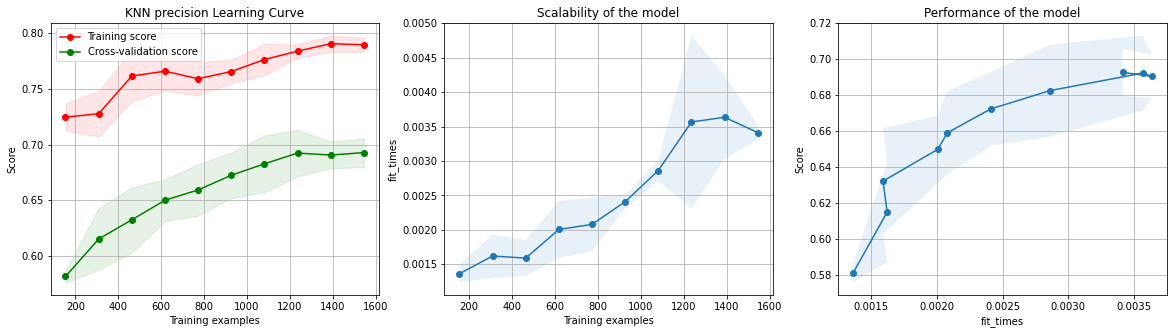

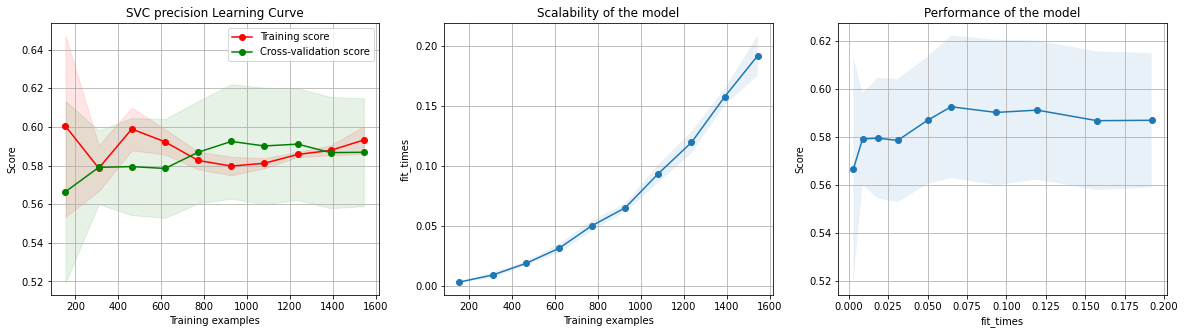

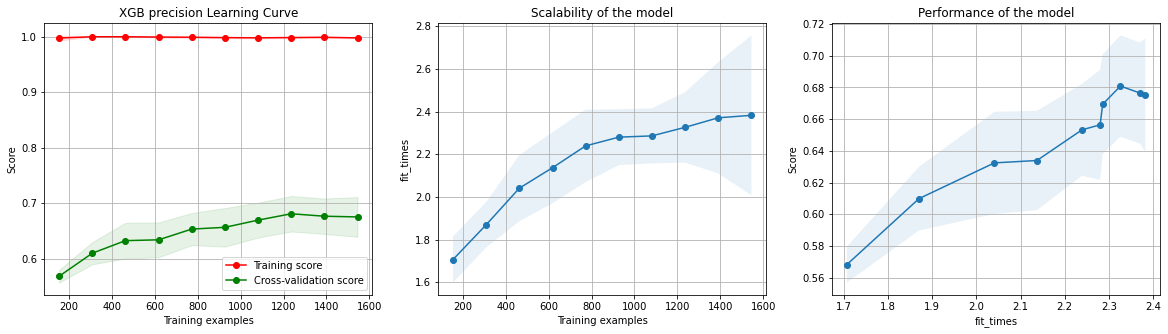

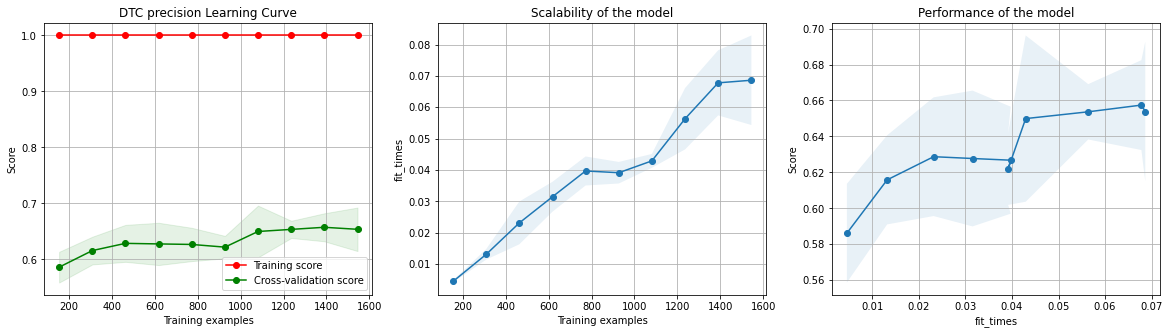

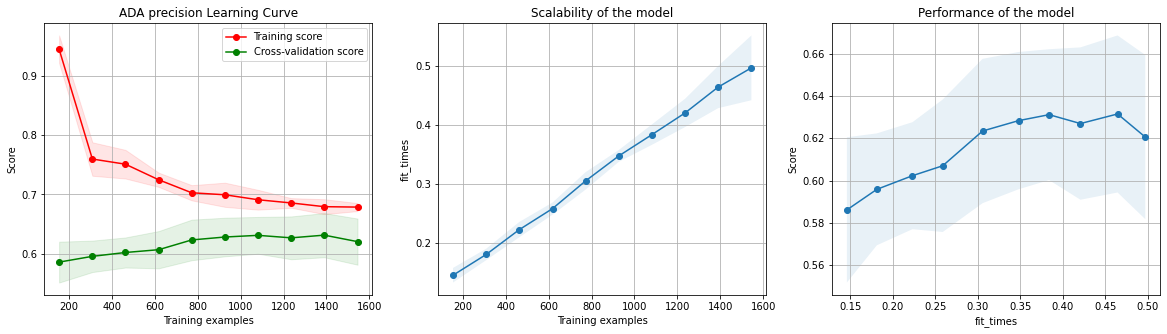

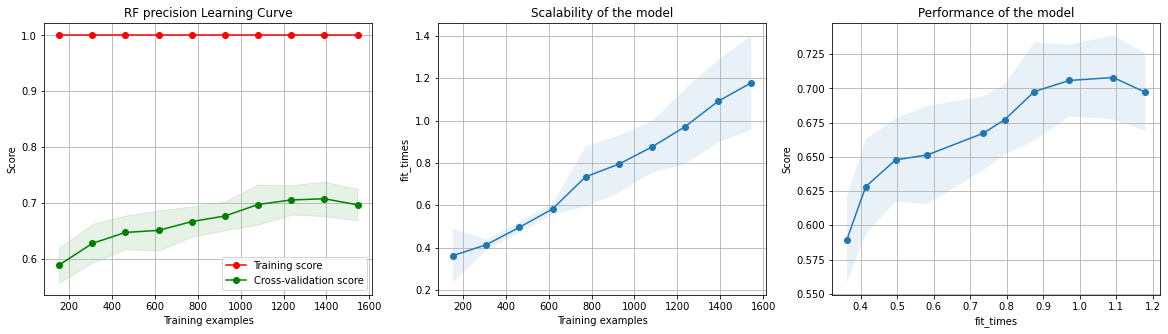

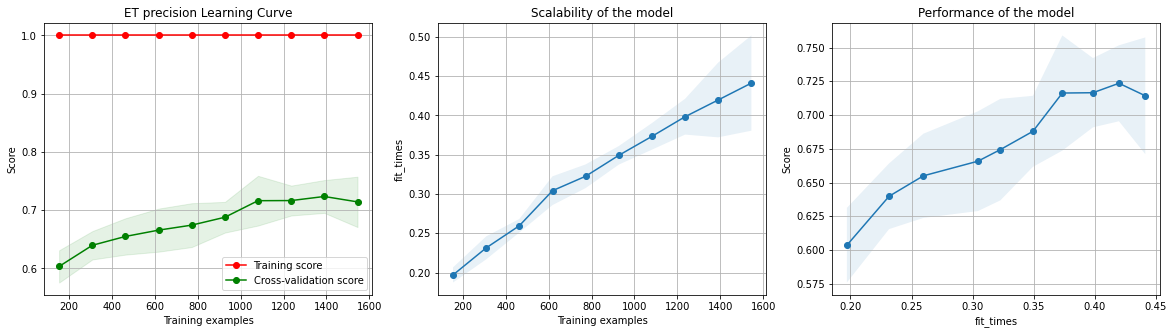

In [26]:
# evaluate model learning curves
model_functions.eval_learning_curves(models=models,x=X_train,
                                     y=y_train,scoring=['accuracy','precision'])

In [27]:
new_models = [('KNN',KNeighborsClassifier()),
          ('XGB',XGBClassifier()),
          ('RF', RandomForestClassifier()),
          ('ET',ExtraTreesClassifier())]


  0%|                                                     | 0/4 [00:00<?, ?it/s]/Users/faithful/anaconda3/envs/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:35:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


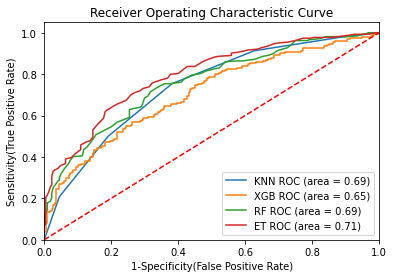

,Model,Precision_score,Recall_score,F1_score,Accuracy
0,KNN,0.689899,0.685985,0.686843,0.692149
1,XGB,0.652309,0.646212,0.646470,0.654959
2,RF,0.691946,0.688258,0.689113,0.694215
3,ET,0.716904,0.714394,0.715196,0.719008


In [28]:
# evaluate model performance report and roc curves
model_functions.eval_model_performance(models=new_models,x_train=X_train,
                                       y_train=y_train,x_test=X_test,y_test=y_test)


## ExtraTrees Hyperparameter Tuning

In [29]:
ExtraTreesClassifier()

ExtraTreesClassifier()

In [30]:
# Number of trees in random forest
etc_n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 11)]
# Number of features to consider at every split
etc_max_features = ["auto", "sqrt", "log2"]
# Maximum number of levels in tree
etc_max_depth = [int(x) for x in np.linspace(5,20, num = 11)]
etc_max_depth.append(None)
# Minimum number of samples required to split a node
etc_min_samples_split = [int(x) for x in range(2,10)]
# Minimum number of samples required at each leaf node
etc_min_samples_leaf = [int(x) for x in range(1,5)]
# Method of selecting samples for training each tree
etc_bootstrap = [True, False]

etc_criterion = ["gini", "entropy"]
# Create the random grid
etc_params = {'n_estimators': etc_n_estimators,
               'max_features': etc_max_features,
               'max_depth': etc_max_depth,
               'min_samples_split': etc_min_samples_split,
               'min_samples_leaf': etc_min_samples_leaf,
               'bootstrap': etc_bootstrap,
               'criterion': etc_criterion}
# use GridsearchCV, set scoring parameters and # of CV 
etc_scoring = 'precision'
etc_kfold = KFold(n_splits=5,random_state=seed,shuffle=True)

gs_etc = GridSearchCV(estimator=ExtraTreesClassifier(),
                        param_grid=etc_params,cv=etc_kfold,n_jobs=-1,verbose=1,scoring=etc_scoring)
gs_etc.fit(X_train,y_train)


Fitting 5 folds for each of 50688 candidates, totalling 253440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 20,
                                       None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [100, 140, 180, 220, 260, 300, 340,
                                          380, 420, 460, 500]},
             scoring='precision', verbose=1)

In [31]:
gs_etc.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 380}

In [34]:
final_etc = ExtraTreesClassifier(n_estimators=380,criterion='entropy',max_features="sqrt")

<module 'matplotlib.pyplot' from '/Users/faithful/anaconda3/envs/venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

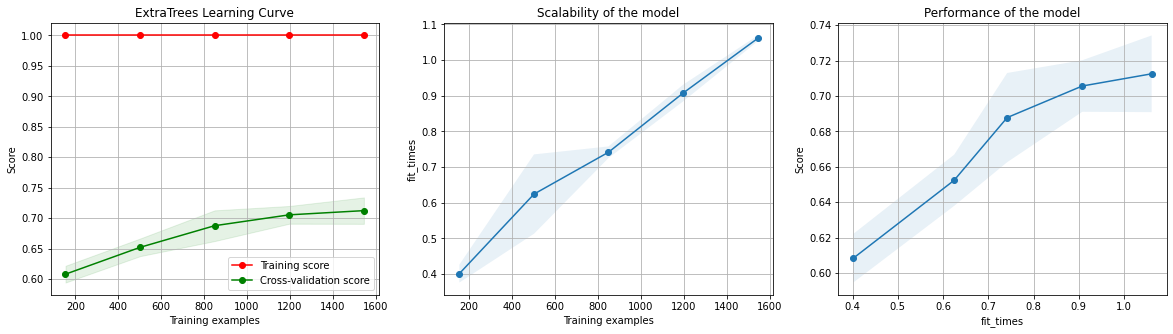

In [35]:
model_functions.plot_learning_curve(estimator=final_etc,title='ExtraTrees Learning Curve',
                                   score='precision',X=X_train,y=y_train)

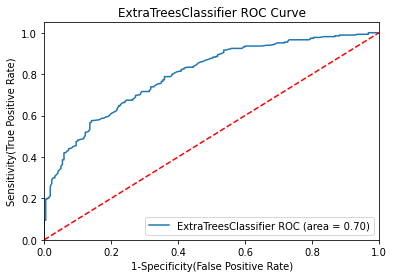

1

In [36]:
model_functions.plot_roc_curve(estimator=final_etc,x_train=X_train,
                               y_train=y_train,x_test=X_test,y_test=y_test)

Confusion matrix, without normalization
[[205  59]
 [ 76 144]]


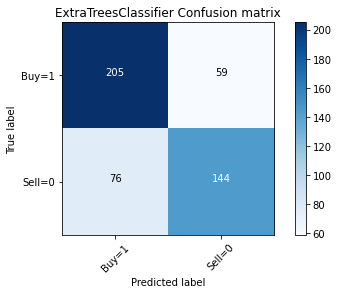

In [38]:
model_functions.plot_confusion_matrix(estimator=final_etc,x_train=X_train,
                               y_train=y_train,x_test=X_test,y_test=y_test,
                                      classes= ['Buy=1','Sell=0'])

## Random Forest  Hyperparameter Tuning

In [51]:
# Number of trees in random forest
forest_n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 11)]
# Number of features to consider at every split
forest_max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
forest_max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
forest_max_depth.append(None)
# Minimum number of samples required to split a node
forest_min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
forest_min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
forest_bootstrap = [True, False]
# Create the random grid
forest_random_grid = {'n_estimators': forest_n_estimators,
               'max_features': forest_max_features,
               'max_depth': forest_max_depth,
               'min_samples_split': forest_min_samples_split,
               'min_samples_leaf': forest_min_samples_leaf,
               'bootstrap': forest_bootstrap}
# use GridsearchCV, set scoring parameters and # of CV 
forest_scoring = 'precision'
forest_kfold = KFold(n_splits=5,random_state=seed,shuffle=True)

gs_rf = GridSearchCV(estimator=RandomForestClassifier(),
                        param_grid=forest_random_grid,cv=forest_kfold,n_jobs=-1,
                     verbose=1,scoring=forest_scoring)
gs_rf.fit(X_train,y_train)

Fitting 5 folds for each of 4752 candidates, totalling 23760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 40.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 48.2min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 56.6min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 65.4min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 140, 180, 220, 260, 300, 340,
                                          380, 420, 460, 500]},
             scoring='precision', verbose=1)

In [52]:
gs_rf.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 340}

In [53]:
final_rf = RandomForestClassifier(n_estimators=340,max_features='sqrt',max_depth=50,bootstrap=False)

<module 'matplotlib.pyplot' from '/Users/faithful/anaconda3/envs/venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

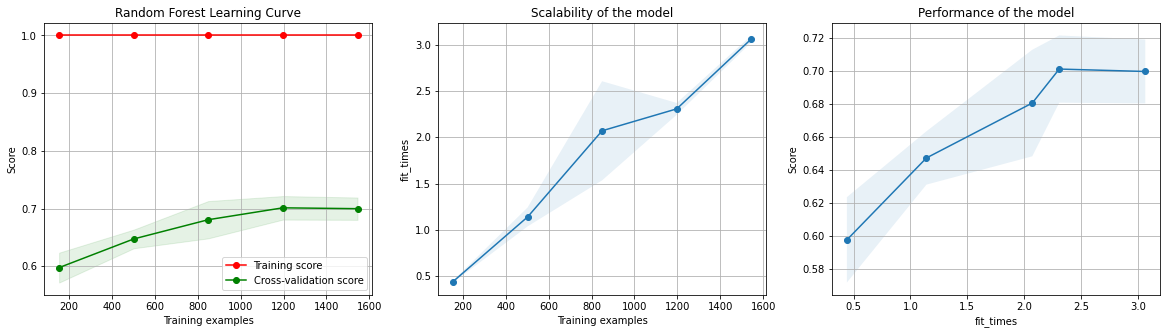

In [54]:
model_functions.plot_learning_curve(estimator=final_rf,title='Random Forest Learning Curve',
                                   score='precision',X=X_train,y=y_train)

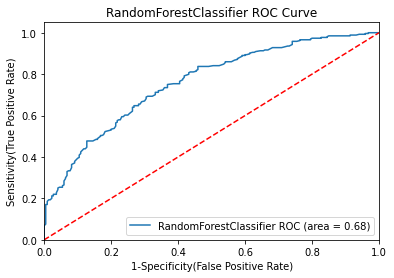

1

In [55]:
model_functions.plot_roc_curve(estimator=final_rf,x_train=X_train,
                               y_train=y_train,x_test=X_test,y_test=y_test)

Confusion matrix, without normalization
[[194  70]
 [ 79 141]]


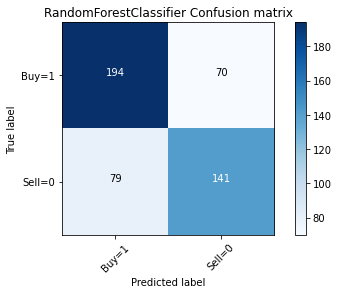

In [56]:
model_functions.plot_confusion_matrix(estimator=final_rf,x_train=X_train,
                               y_train=y_train,x_test=X_test,y_test=y_test,
                                      classes= ['Buy=1','Sell=0'])

## KNN  Hyperparameter Tuning

In [45]:
# Method of selecting samples for training each tree
knn_neighbors = [int(x) for x in np.linspace(3, 11, num = 5)]
# Create the random grid
knn_grid = {'n_neighbors': knn_neighbors
            }
# use GridsearchCV, set scoring parameters and # of CV 
knn_scoring = 'precision'
knn_kfold = KFold(n_splits=5,random_state=seed,shuffle=True)

gs_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                        param_grid=knn_grid,cv=knn_kfold,n_jobs=-1,
                     verbose=1,scoring=knn_scoring)
gs_knn.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11]}, scoring='precision',
             verbose=1)

In [46]:
gs_knn.best_params_

{'n_neighbors': 3}

In [47]:
final_knn = KNeighborsClassifier(n_neighbors=3)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


<module 'matplotlib.pyplot' from '/Users/faithful/anaconda3/envs/venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

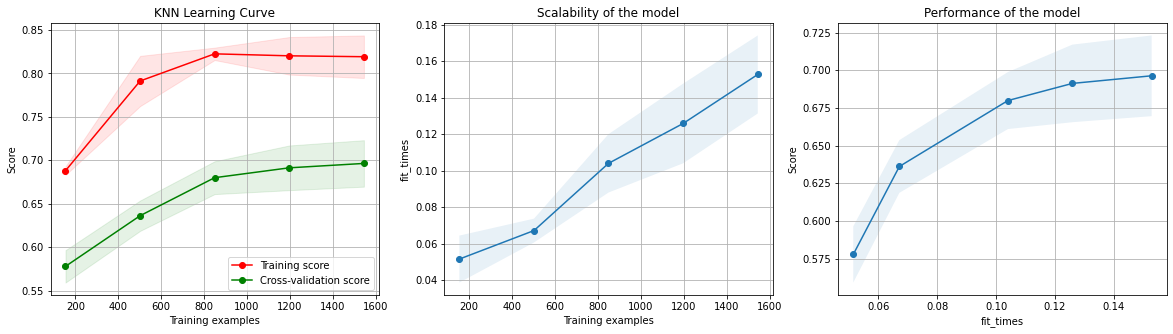

In [48]:
model_functions.plot_learning_curve(estimator=gs_knn,title='KNN Learning Curve',
                                   score='precision',X=X_train,y=y_train)

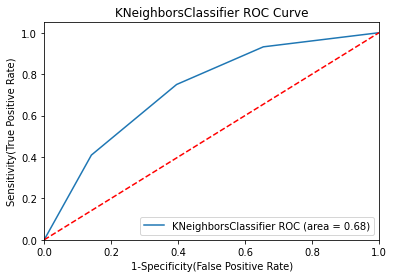

1

In [49]:
model_functions.plot_roc_curve(estimator=final_knn,x_train=X_train,
                               y_train=y_train,x_test=X_test,y_test=y_test)

Confusion matrix, without normalization
[[198  66]
 [ 87 133]]


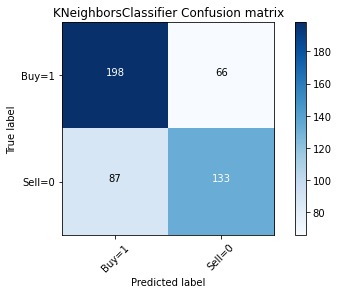

In [50]:
model_functions.plot_confusion_matrix(estimator=final_knn,x_train=X_train,
                               y_train=y_train,x_test=X_test,y_test=y_test,
                                      classes= ['Buy=1','Sell=0'])

# Testing final KNN Model on New dataset

In [57]:
test_data

,prediction_date,open_price_1,open_price_2,open_price_3,open_price_4,open_price_5,open_price_6,high_1,high_2,high_3,...,close_price_4,close_price_5,close_price_6,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,signal
1739,2019-10-10,8259.49,8210.15,8149.88,7989.12,8246.85,8229.84,8260.06,8215.53,8161.41,...,8245.62,8228.78,8595.74,13139456229,12200497197,13160830305,18009742607,15592264032,19384942333,0
1783,2019-11-24,8573.98,8305.13,8203.61,8023.64,7643.57,7296.16,8653.28,8408.52,8237.24,...,7642.75,7296.58,7397.80,21579470673,21083613816,20764300437,22514243371,34242315785,21008924418,1
1253,2018-06-12,7625.97,7650.82,7685.14,7632.52,7499.55,6799.29,7680.43,7741.27,7698.19,...,7531.98,6786.02,6906.92,4692259840,4485799936,4227579904,3845220096,5804839936,4745269760,1
1176,2018-03-27,8937.48,8939.44,8736.25,8901.95,8612.81,8498.47,9177.37,9100.71,8879.62,...,8668.12,8495.78,8209.40,6043129856,5530390016,5954120192,5664600064,4569880064,5921039872,0
1213,2018-05-03,9290.63,8939.27,9346.41,9426.11,9251.47,9104.60,9375.47,9412.09,9531.49,...,9240.55,9119.01,9235.92,7566289920,7805479936,8853000192,8673920000,7713019904,7558159872,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,2020-04-06,6430.61,6437.32,6606.78,6797.40,6738.38,6862.54,6504.52,6612.57,7088.25,...,6733.39,6867.53,6791.13,32786468812,40346426266,47660646124,38976504903,33185988584,29510409856,0
916,2017-07-10,2561.00,2602.87,2608.10,2608.59,2520.27,2572.61,2631.59,2622.65,2616.72,...,2518.66,2571.34,2518.44,985516032,941566016,761956992,917411968,733329984,527856000,0
1251,2018-06-10,7722.53,7500.90,7625.97,7650.82,7685.14,7632.52,7753.82,7643.23,7680.43,...,7678.24,7624.92,7531.98,4993169920,4961739776,4692259840,4485799936,4227579904,3845220096,0
628,2016-09-25,609.87,609.25,603.59,597.28,596.20,602.96,610.93,609.53,603.59,...,596.30,602.84,602.62,54796400,72710896,82776200,67085300,51067000,35359500,1


In [58]:
# drop date column
test_data.drop('prediction_date',axis=1,inplace=True)

/Users/faithful/anaconda3/envs/venv/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [59]:
test_data

,open_price_1,open_price_2,open_price_3,open_price_4,open_price_5,open_price_6,high_1,high_2,high_3,high_4,...,close_price_4,close_price_5,close_price_6,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,signal
1739,8259.49,8210.15,8149.88,7989.12,8246.85,8229.84,8260.06,8215.53,8161.41,8308.45,...,8245.62,8228.78,8595.74,13139456229,12200497197,13160830305,18009742607,15592264032,19384942333,0
1783,8573.98,8305.13,8203.61,8023.64,7643.57,7296.16,8653.28,8408.52,8237.24,8110.10,...,7642.75,7296.58,7397.80,21579470673,21083613816,20764300437,22514243371,34242315785,21008924418,1
1253,7625.97,7650.82,7685.14,7632.52,7499.55,6799.29,7680.43,7741.27,7698.19,7683.58,...,7531.98,6786.02,6906.92,4692259840,4485799936,4227579904,3845220096,5804839936,4745269760,1
1176,8937.48,8939.44,8736.25,8901.95,8612.81,8498.47,9177.37,9100.71,8879.62,8996.18,...,8668.12,8495.78,8209.40,6043129856,5530390016,5954120192,5664600064,4569880064,5921039872,0
1213,9290.63,8939.27,9346.41,9426.11,9251.47,9104.60,9375.47,9412.09,9531.49,9477.14,...,9240.55,9119.01,9235.92,7566289920,7805479936,8853000192,8673920000,7713019904,7558159872,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,6430.61,6437.32,6606.78,6797.40,6738.38,6862.54,6504.52,6612.57,7088.25,7003.22,...,6733.39,6867.53,6791.13,32786468812,40346426266,47660646124,38976504903,33185988584,29510409856,0
916,2561.00,2602.87,2608.10,2608.59,2520.27,2572.61,2631.59,2622.65,2616.72,2916.14,...,2518.66,2571.34,2518.44,985516032,941566016,761956992,917411968,733329984,527856000,0
1251,7722.53,7500.90,7625.97,7650.82,7685.14,7632.52,7753.82,7643.23,7680.43,7741.27,...,7678.24,7624.92,7531.98,4993169920,4961739776,4692259840,4485799936,4227579904,3845220096,0
628,609.87,609.25,603.59,597.28,596.20,602.96,610.93,609.53,603.59,598.49,...,596.30,602.84,602.62,54796400,72710896,82776200,67085300,51067000,35359500,1


In [60]:
final_X_test = test_data.drop("signal",axis=1)

In [61]:
scaler = StandardScaler()
scaler.fit_transform(X_train)
final_X_test= scaler.transform(final_X_test)

In [62]:
final_y_test = test_data["signal"]

In [63]:
def final_model_test(model,final_x,final_y):
    
    # model makes a prediction
    #model.fit(final_x,final_y)
    y_pred=model.predict(final_X_test)
    print("Prediction completed.")
    df_test=pd.DataFrame({"Actual": final_y_test,
                     "Predicted":y_pred})
    df_test["difference"]=df_test['Predicted']-df_test['Actual']
    df_test.reset_index(inplace=True)
    print(f" Model Accuracy is: {model.score(X=final_X_test,y=final_y_test)*100}%")
    # plot confusion matrix
    plot_confusion_matrix(estimator=model,X=final_x,y_true=final_y)
    return 0
    

Prediction completed.
 Model Accuracy is: 53.5%


0

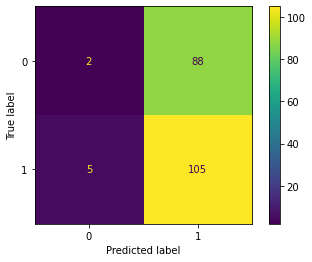

In [64]:
final_model_test(model=final_knn,final_x=final_X_test,final_y=final_y_test)

Prediction completed.
 Model Accuracy is: 45.0%


0

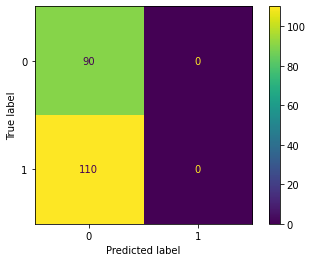

In [65]:
final_model_test(model=final_etc,final_x=final_X_test,final_y=final_y_test)

Prediction completed.
 Model Accuracy is: 45.0%


0

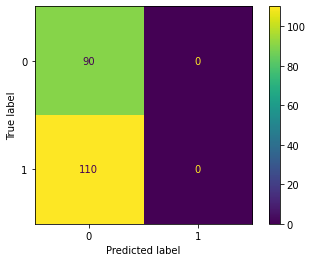

In [66]:
final_model_test(model=final_rf,final_x=final_X_test,final_y=final_y_test)

In [103]:
final_knn

'uniform'

## Finalizing  Model 

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2533 entries, 931 to 331
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   prediction_date  2533 non-null   object 
 1   open_price_1     2533 non-null   float64
 2   open_price_2     2533 non-null   float64
 3   open_price_3     2533 non-null   float64
 4   open_price_4     2533 non-null   float64
 5   open_price_5     2533 non-null   float64
 6   open_price_6     2533 non-null   float64
 7   high_1           2533 non-null   float64
 8   high_2           2533 non-null   float64
 9   high_3           2533 non-null   float64
 10  high_4           2533 non-null   float64
 11  high_5           2533 non-null   float64
 12  high_6           2533 non-null   float64
 13  low_1            2533 non-null   float64
 14  low_2            2533 non-null   float64
 15  low_3            2533 non-null   float64
 16  low_4            2533 non-null   float64
 17  low_5        

In [25]:
# drop prediction date
df.drop('prediction_date',axis=1,inplace=True)

In [26]:
# split the data into train test split, create test size & random seed
final_X = df.drop('signal',axis=1)
final_y = df['signal']

In [27]:
# create final model and pipeline operation
knn3 = KNeighborsClassifier(n_neighbors=3)
operations = [('scaler',scaler),('knn3',knn3)]

In [28]:
pipe = Pipeline(operations)

In [29]:
pipe.fit(final_X,final_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn3', KNeighborsClassifier(n_neighbors=3))])

In [30]:
# To save you model
dump(pipe,'final_model.joblib')

['final_model.joblib']

Prediction completed.
 Model Accuracy is: 88.0%


0

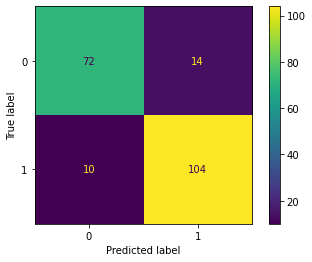

In [43]:
final_model_test(model=pipe,final_x=final_X_test,final_y=final_y_test)